<a href="https://colab.research.google.com/github/NanaKwakuOsei-Opoku/Interpretable-Landslide-Detection-System/blob/main/Landslide4Sense_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation of required libraries and basic setup

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
import os
import glob
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%cd /content/gdrive/MyDrive/Colab\ Notebooks
!ls



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks
'Copy of Landslide4Sense solution.ipynb'  'Landslide4Sense solution.ipynb'   __pycache__   utils.py
 data					   model			     Unet.py


# Data Loading & Preprocessing

In [3]:

def load_dataset(image_paths, mask_paths=None):
    valid_images = []
    valid_masks = [] if mask_paths is not None else None
    corrupted_images_count = 0
    corrupted_masks_count = 0

    for i, img_path in enumerate(image_paths):
        try:
            with h5py.File(img_path, 'r') as hdf:
                data = np.array(hdf.get('img'), dtype=np.float32)
        except Exception as e:
            print(f"Skipping image file {img_path} due to error: {e}")
            corrupted_images_count += 1
            continue

        # Replace NaNs and compute mid values
        data[np.isnan(data)] = 1e-6
        mid_rgb       = data[:, :, 1:4].max() / 2.0
        mid_slope     = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # NDVI calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        ndvi = np.divide(data_nir - data_red, (data_nir + data_red) + 1e-6)

        # Build the 6‐channel image
        img_array = np.empty((128, 128, 6), dtype=np.float32)
        img_array[:, :, 0] = 1.0 - (data[:, :, 3] / (mid_rgb + 1e-6))     # R
        img_array[:, :, 1] = 1.0 - (data[:, :, 2] / (mid_rgb + 1e-6))     # G
        img_array[:, :, 2] = 1.0 - (data[:, :, 1] / (mid_rgb + 1e-6))     # B
        img_array[:, :, 3] = ndvi
        img_array[:, :, 4] = 1.0 - (data[:, :, 12] / (mid_slope + 1e-6))  # Slope
        img_array[:, :, 5] = 1.0 - (data[:, :, 13] / (mid_elevation + 1e-6))  # Elevation

        valid_images.append(img_array)

        if mask_paths is not None:
            try:
                with h5py.File(mask_paths[i], 'r') as hdf_mask:
                    mask_data = np.array(hdf_mask.get('mask'), dtype=np.float32)
                valid_masks.append(mask_data)
            except Exception as e:
                print(f"Skipping mask file {mask_paths[i]} due to error: {e}")
                corrupted_masks_count += 1
                continue

    X = np.array(valid_images)
    Y = np.array(valid_masks) if mask_paths is not None else None

    # Print summary
    print("Dataset loading completed:")
    print(f"Total image files provided: {len(image_paths)}")
    print(f"Valid images loaded: {X.shape[0]}")
    print(f"Corrupted/failed image files: {corrupted_images_count}")

    if mask_paths is not None:
        print(f"Total mask files provided: {len(mask_paths)}")
        print(f"Valid masks loaded: {Y.shape[0]}")
        print(f"Corrupted/failed mask files: {corrupted_masks_count}")

        # Count landslide‐positive vs. negative
        positive_count = sum(np.sum(mask) > 0 for mask in Y)
        negative_count = Y.shape[0] - positive_count
        print(f"Landslide positive images (mask > 0): {positive_count}")
        print(f"Non‐landslide images (mask sum == 0): {negative_count}")

    return X, Y


# Preparing Training and Validation

Dataset loading completed:
Total image files provided: 1000
Valid images loaded: 1000
Corrupted/failed image files: 0
Total mask files provided: 1000
Valid masks loaded: 1000
Corrupted/failed mask files: 0
Landslide positive images (mask > 0): 724
Non‐landslide images (mask sum == 0): 276
Train data shape: (1000, 128, 128, 6) (1000, 128, 128)
Train stats: -0.99999976 1.0 0.0 1.0


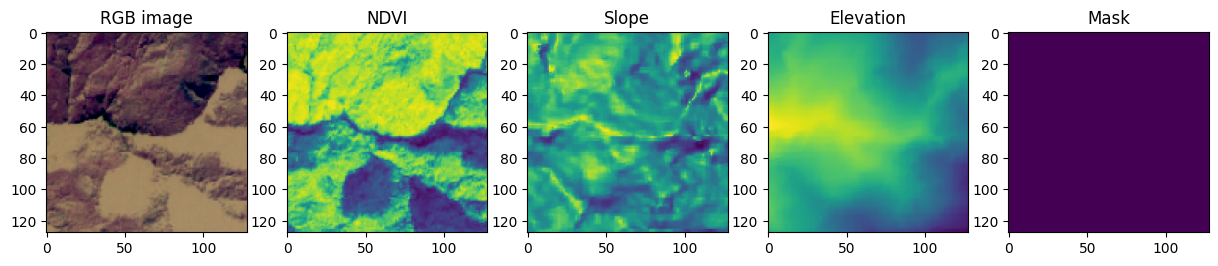

In [4]:
import glob, os
import matplotlib.pyplot as plt

os.chdir('/content/gdrive/MyDrive/Colab Notebooks/data')

TRAIN_PATH = sorted(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/data/TrainData/img/*.h5"))[:1000]
TRAIN_MASK = sorted(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/data/TrainData/mask/*.h5"))[:1000]

# Load entire training set
TRAIN_XX, TRAIN_YY = load_dataset(TRAIN_PATH, TRAIN_MASK)

print("Train data shape:", TRAIN_XX.shape, TRAIN_YY.shape)
if TRAIN_XX.size > 0 and TRAIN_YY.size > 0:
    print("Train stats:", TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())
else:
    print("No data loaded. Check file paths and dataset.")

# Train/validation split
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle=True
)

del TRAIN_XX, TRAIN_YY  # free memory if desired

# Expand mask dims
y_train = np.expand_dims(y_train, axis=-1)  # (80, 128, 128, 1)
y_valid = np.expand_dims(y_valid, axis=-1)  # (20, 128, 128, 1)




In [ ]:
# Quick visualization
sample_idx = 6
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10))
ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")

ax1.imshow(x_train[sample_idx, :, :, 0:3])
ax2.imshow(x_train[sample_idx, :, :, 3])
ax3.imshow(x_train[sample_idx, :, :, 4])
ax4.imshow(x_train[sample_idx, :, :, 5])
ax5.imshow(y_train[sample_idx, :, :, 0])
plt.show()

In [5]:
import tensorflow as tf

# Example: random horizontal & vertical flips
@tf.function
def random_flip(image, mask):
    # Flip left-right
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    # Flip up-down
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    return image, mask

# Create tf.data Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(random_flip, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(16).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_ds = valid_ds.batch(16).prefetch(tf.data.AUTOTUNE)


In [6]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    # BinaryCrossentropy expects y_pred to be probabilities if from a sigmoid layer
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dc = dice_loss(y_true, y_pred)
    return bce + dc

def _unify_dims(y_true, y_pred):
    if y_true.shape.ndims == 3:
        y_true = tf.expand_dims(y_true, axis=-1)
    return y_true, y_pred

def recall_m(y_true, y_pred):
    y_true, y_pred = _unify_dims(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    y_true, y_pred = _unify_dims(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    y_true, y_pred = _unify_dims(y_true, y_pred)
    prec = precision_m(y_true, y_pred)
    rec = recall_m(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())


## Building and Compiling the UNET


In [7]:
import tensorflow as tf

def aspp_module(inputs, filter_size=256):
    """Atrous Spatial Pyramid Pooling (ASPP) for multi-scale context."""
    # 1x1 convolution
    conv1 = tf.keras.layers.Conv2D(filter_size, (1, 1), padding='same',
                                   kernel_initializer='he_normal', activation='relu')(inputs)

    # Atrous convolutions with different dilation rates
    conv3_1 = tf.keras.layers.Conv2D(filter_size, (3, 3), padding='same',
                                     dilation_rate=1, kernel_initializer='he_normal',
                                     activation='relu')(inputs)

    conv3_6 = tf.keras.layers.Conv2D(filter_size, (3, 3), padding='same',
                                     dilation_rate=6, kernel_initializer='he_normal',
                                     activation='relu')(inputs)

    conv3_12 = tf.keras.layers.Conv2D(filter_size, (3, 3), padding='same',
                                      dilation_rate=12, kernel_initializer='he_normal',
                                      activation='relu')(inputs)

    conv3_18 = tf.keras.layers.Conv2D(filter_size, (3, 3), padding='same',
                                      dilation_rate=18, kernel_initializer='he_normal',
                                      activation='relu')(inputs)

    # Global average pooling
    pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    pool = tf.keras.layers.Reshape((1, 1, tf.keras.backend.int_shape(pool)[-1]))(pool)
    pool = tf.keras.layers.Conv2D(filter_size, (1, 1), padding='same',
                                  kernel_initializer='he_normal', activation='relu')(pool)
    pool = tf.keras.layers.UpSampling2D(size=(tf.keras.backend.int_shape(inputs)[1],
                                              tf.keras.backend.int_shape(inputs)[2]),
                                        interpolation='bilinear')(pool)

    # Concatenate all the layers
    aspp = tf.keras.layers.concatenate([conv1, conv3_1, conv3_6, conv3_12, conv3_18, pool], axis=-1)
    output = tf.keras.layers.Conv2D(filter_size, (1, 1), padding='same',
                                    kernel_initializer='he_normal', activation='relu')(aspp)
    return output

def unet_with_aspp(img_height, img_width, img_channels):
    inputs = tf.keras.layers.Input((img_height, img_width, img_channels))

    # Contracting Path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck with ASPP
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = aspp_module(c5)  # Adding ASPP module here

    # Expansive Path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_with_aspp(128, 128, 6)
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[f1_m, precision_m, recall_m]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "/content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras",
        monitor="val_f1_m",
        verbose=1,
        save_best_only=True,
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_m',
        patience=10,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)



Epoch 1: val_f1_m improved from -inf to 0.53132, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
50/50 - 43s - 852ms/step - f1_m: 0.1798 - loss: 0.9231 - precision_m: 0.4496 - recall_m: 0.1887 - val_f1_m: 0.5313 - val_loss: 0.5873 - val_precision_m: 0.5099 - val_recall_m: 0.5811
Epoch 2/100

Epoch 2: val_f1_m improved from 0.53132 to 0.62254, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
50/50 - 4s - 78ms/step - f1_m: 0.6224 - loss: 0.4798 - precision_m: 0.6111 - recall_m: 0.6648 - val_f1_m: 0.6225 - val_loss: 0.4706 - val_precision_m: 0.6650 - val_recall_m: 0.5961
Epoch 3/100

Epoch 3: val_f1_m improved from 0.62254 to 0.65667, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
50/50 - 5s - 96ms/step - f1_m: 0.6543 - loss: 0.4356 - precision_m: 0.6510 - recall_m: 0.6781 - val_f1_m: 0.6567 - val_loss: 0.4257 - val_precision_m: 0.6405 - val_recall_m: 0.6829
Epoch 4/100

Epoch 4: val_f1_m improve

## Training with Callbacks


## Evaluate

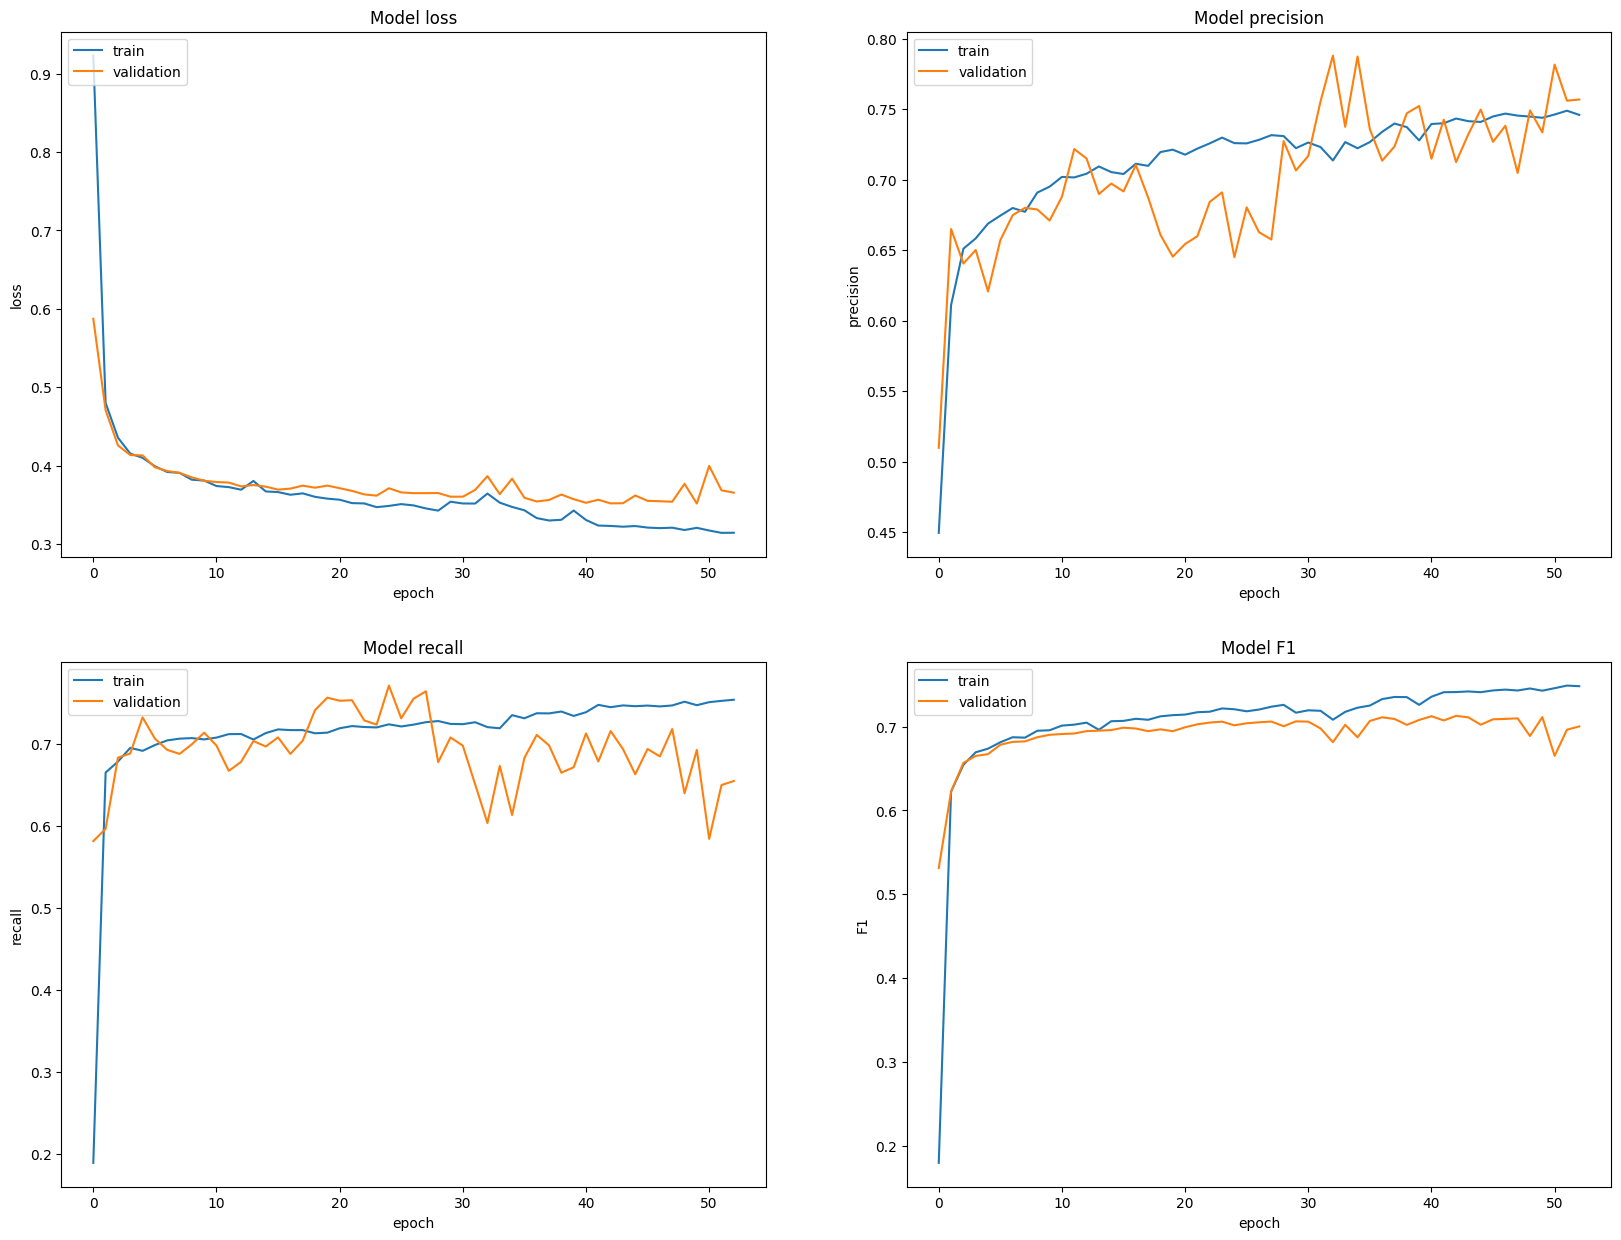

In [8]:

# Plot training history
fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.set_title('Model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Model F1')
ax14.set_ylabel('F1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')
plt.show()


## Prediction Example

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


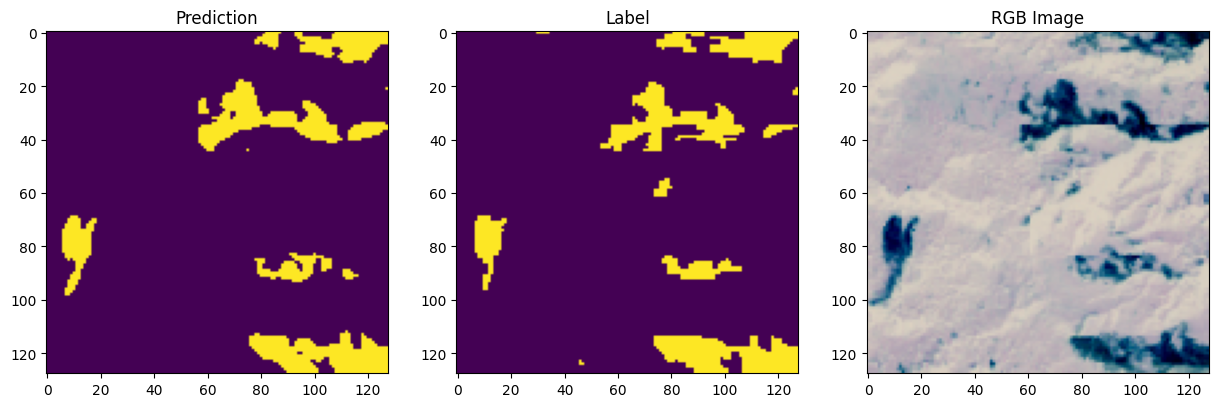

In [13]:
threshold = 0.5
pred_img = model.predict(x_valid)  # shape: (num_samples, 128, 128, 1)
pred_img = (pred_img > threshold).astype(np.uint8)

img_idx = 20
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
ax1.imshow(pred_img[img_idx, :, :, 0])
ax1.set_title("Prediction")
ax2.imshow(y_valid[img_idx, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img_idx, :, :, 0:3])
ax3.set_title("RGB Image")
plt.show()


## Validating on New Data

Dataset loading completed:
Total image files provided: 245
Valid images loaded: 245
Corrupted/failed image files: 0
Validation images shape: (245, 128, 128, 6)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


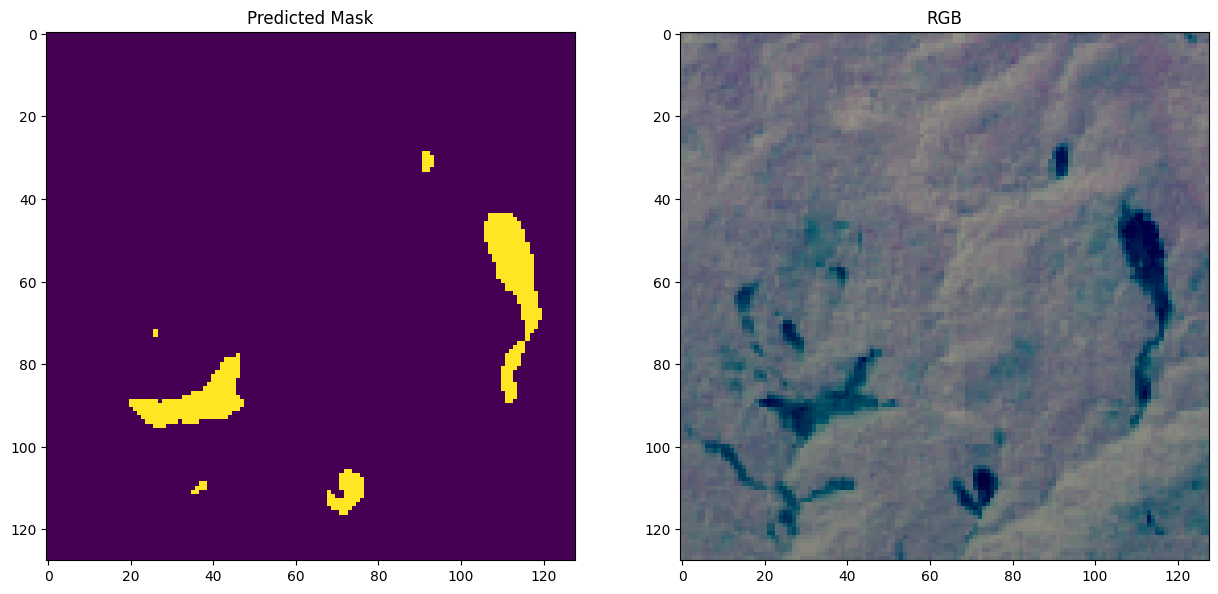

In [20]:
validation_url = "/content/gdrive/MyDrive/Colab Notebooks/data/ValidateData/*.h5"
img_val_paths = sorted(glob.glob(validation_url))

VAL_XX, _ = load_dataset(img_val_paths, mask_paths=None)
print("Validation images shape:", VAL_XX.shape)

val_preds = model.predict(VAL_XX)
val_preds = (val_preds > threshold).astype(np.uint8)

img_val_idx = 1
fig, (axv1, axv2) = plt.subplots(1, 2, figsize=(15, 10))
axv1.imshow(val_preds[img_val_idx, :, :, 0])
axv1.set_title("Predicted Mask")
axv2.imshow(VAL_XX[img_val_idx, :, :, 0:3])
axv2.set_title("RGB")
plt.show()

# Optionally save predicted masks
write_directory = "data/validation/mask"
os.makedirs(write_directory, exist_ok=True)
for i, img_path in enumerate(img_val_paths):
    name = os.path.basename(img_path).replace("image", "mask")
    with h5py.File(os.path.join(write_directory, name), 'w') as h5f:
        pred_mask = val_preds[i, :, :, 0]
        h5f.create_dataset('mask', data=pred_mask)


## Interpretability: Saliency Map & Grad-CAM

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 6))
  warnings.warn(msg)


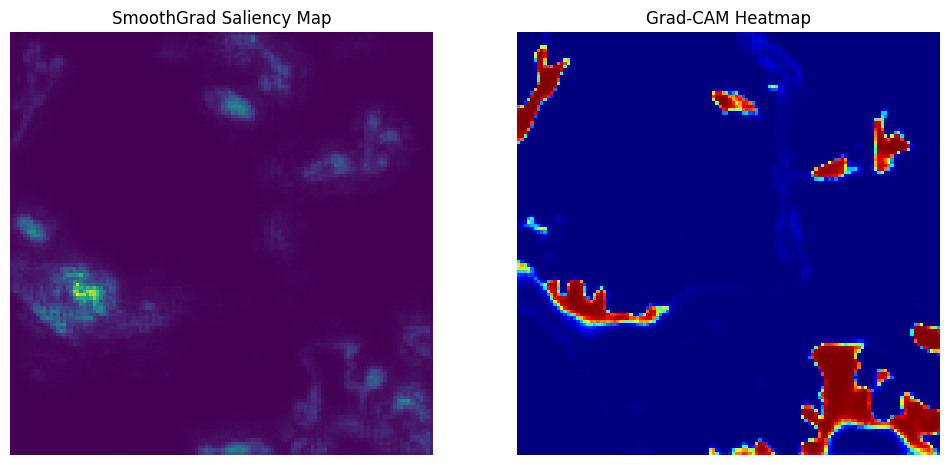

In [21]:
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K

def compute_saliency_smoothgrad(model, x, class_idx=None, num_samples=15, noise_level=0.1):

    def single_pass_saliency(model, x_input, class_idx):
        x_var = tf.Variable(x_input, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(x_var)
            prediction = model(x_var, training=False)  # shape: (1, H, W, 1)
            if class_idx is not None:
                # e.g. prediction[0, row, col, 0]
                loss = prediction[0, :, :, 0][class_idx]
            else:
                # Sum over entire predicted mask
                loss = tf.reduce_sum(prediction)
        grads = tape.gradient(loss, x_var)
        # Take absolute value across channels, then max along channel axis
        sal = tf.reduce_max(tf.abs(grads), axis=-1)[0]  # shape: (H, W)
        return sal.numpy()

    accum_saliency = np.zeros((x.shape[1], x.shape[2]), dtype=np.float32)
    x_std = np.std(x)  # to scale noise

    for _ in range(num_samples):
        noise = np.random.normal(0, noise_level * x_std, x.shape).astype(np.float32)
        x_noisy = x + noise
        accum_saliency += single_pass_saliency(model, x_noisy, class_idx)

    smooth_saliency = accum_saliency / num_samples
    return smooth_saliency

def grad_cam_segmentation(model, x, layer_name=None):
    if layer_name is None:
        # Heuristically pick the last Conv2D layer in your model
        layer_name = [l.name for l in model.layers if 'conv2d' in l.name][-1]

    # Sub-model returning (feature_maps, predictions)
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        feature_maps, predictions = grad_model(x, training=False)
        # We'll define the loss as the sum over the entire mask
        loss = tf.reduce_sum(predictions)

    grads = tape.gradient(loss, feature_maps)
    # Global average pooling on the grads
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the pooled gradient
    feature_maps = feature_maps[0]  # remove batch dimension
    heatmap = tf.reduce_sum(feature_maps * pooled_grads, axis=-1)

    # ReLU
    heatmap = tf.maximum(heatmap, 0)
    # Normalize
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap / (max_val + 1e-6)
    heatmap = heatmap.numpy()

    # Resize to match original input size
    h, w = x.shape[1], x.shape[2]
    heatmap = cv2.resize(heatmap, (w, h))
    return heatmap

# --- Example usage on one validation image ---
test_img = x_valid[None, 0, ...]  # shape: (1, 128, 128, 6)

# Compute SmoothGrad Saliency
smooth_saliency_map = compute_saliency_smoothgrad(
    model, test_img,
    class_idx=None,   # or (row, col) if focusing on a specific pixel
    num_samples=15,   # try 15-50 for more smoothing
    noise_level=0.1
)

# Compute Grad-CAM
gradcam_map = grad_cam_segmentation(model, test_img)

# Visualize
fig, (ax_s, ax_g) = plt.subplots(1, 2, figsize=(12, 6))
ax_s.imshow(smooth_saliency_map, cmap='viridis')
ax_s.set_title("SmoothGrad Saliency Map")
ax_s.axis('off')

ax_g.imshow(gradcam_map, cmap='jet')
ax_g.set_title("Grad-CAM Heatmap")
ax_g.axis('off')
plt.show()


# Sensitivity Analysis


In [22]:
def channel_sensitivity(model, x, channel_idx, baseline='zero'):
    original_pred = model.predict(x)[0, :, :, 0]

    x_mod = x.copy()
    if baseline == 'zero':
        x_mod[0, :, :, channel_idx] = 0.0
    else:
        # set channel to mean value
        mean_val = np.mean(x_mod[0, :, :, channel_idx])
        x_mod[0, :, :, channel_idx] = mean_val

    new_pred = model.predict(x_mod)[0, :, :, 0]
    diff = np.abs(original_pred - new_pred)
    mean_diff = diff.mean()
    return mean_diff

# Example usage: measure each channel’s importance
test_img = x_valid[None, 0, ...]  # pick one image
num_channels = test_img.shape[-1]
for c in range(num_channels):
    sensitivity = channel_sensitivity(model, test_img, c, baseline='zero')
    print(f"Channel {c} sensitivity (zero baseline):", sensitivity)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Channel 0 sensitivity (zero baseline): 0.13150474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Channel 1 sensitivity (zero baseline): 0.058811966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Channel 2 sensitivity (zero baseline): 0.044299066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Channel 3 sensitivity (zero baseline): 0.07630831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Channel 4 sensitivity (zero baseline): 0.13128477
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Channel 5 sensitivity (zero baseline): 0.0057323216


## Implementing LIME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=dbb96023e57d4da08180e7f3f4f9475ad4caa0a125c7d1a96443ab8412e16e27
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

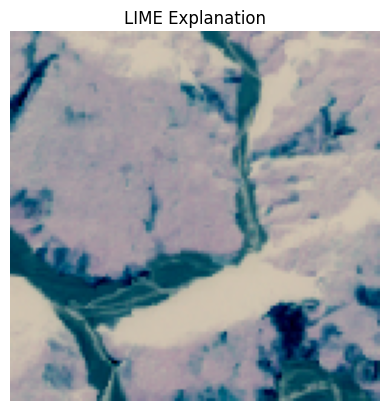

In [26]:
!pip install lime
from lime import lime_image
from skimage.segmentation import slic


def explain_with_lime(model, image, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    # Function to predict using the U-Net model; note that LIME expects a 3D image input
    def model_predict(images):
        images = np.array(images)
        # Assuming images are 128x128 with 6 channels
        preds = model.predict(images)
        # Return predictions in a suitable format; for segmentation, you might flatten the output or summarize per region.
        return preds.reshape((images.shape[0], -1))

    explanation = explainer.explain_instance(
        image.astype('double'),
        model_predict,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)
    )
    return explanation

# Select a representative validation image (e.g., the same test_img used for saliency/Grad-CAM)
lime_explanation = explain_with_lime(model, x_valid[0])

# Visualize the explanation (this depends on how you want to overlay the superpixel weights)
temp, mask = lime_explanation.get_image_and_mask(
    label=lime_explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.imshow(temp[..., :3])
plt.title("LIME Explanation")
plt.axis('off')
plt.show()
